In [53]:
# Importing the libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [54]:
bank_data = pd.read_csv('bank_data.csv')
bank_data.head()

,Unnamed: 0,id,dependents,education,self_employed,income_annual,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,0,1,2,Graduate,No,9600000.0,29900000,12,778,2400000,17600000,22700000,NaN,Approved
1,1,2,0,Not Graduate,Yes,4100000.0,12200000,8,417,2700000,2200000,8800000,3300000.0,Rejected
2,2,3,3,Graduate,No,9100000.0,29700000,20,506,7100000,4500000,33300000,12800000.0,Rejected
3,3,4,3,Graduate,No,8200000.0,30700000,8,467,18200000,3300000,23300000,7900000.0,Rejected
4,4,5,5,Not Graduate,Yes,9800000.0,24200000,20,382,12400000,8200000,29400000,5000000.0,Rejected


In [55]:
#check for NaN values
bank_data.isnull().sum()

Unnamed: 0                    0
id                            0
dependents                    0
education                     0
self_employed                 0
income_annual               213
loan_amount                   0
loan_term                     0
cibil_score                   0
residential_assets_value      0
commercial_assets_value       0
luxury_assets_value           0
bank_asset_value            341
loan_status                   0
dtype: int64

In [56]:
# Calculate descriptive statistics for numerical columns
numerical_col_descriptive_stats = bank_data.describe()
numerical_col_descriptive_stats

,Unnamed: 0,id,dependents,income_annual,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4268.000000,4268.000000,4268.000000,4.055000e+03,4.268000e+03,4268.000000,4268.000000,4.268000e+03,4.268000e+03,4.268000e+03,3.927000e+03
mean,2133.500000,2134.500000,2.499063,5.049420e+06,1.513004e+07,10.900656,599.934396,7.470197e+06,4.971556e+06,1.512149e+07,4.958365e+06
std,1232.209804,1232.209804,1.695954,2.799091e+06,9.041673e+06,5.709840,172.450571,6.502476e+06,4.388236e+06,9.099370e+06,3.262255e+06
min,0.000000,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1066.750000,1067.750000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2133.500000,2134.500000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.500000e+06
75%,3200.250000,3201.250000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4267.000000,4268.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


In [57]:
# Summary of categorical data
categorical_col_descriptive_stats = bank_data.describe(include=['O'])
categorical_col_descriptive_stats

,education,self_employed,loan_status
count,4268,4268,4268
unique,2,2,2
top,Graduate,Yes,Approved
freq,2143,2150,2655


In [58]:
# Grouping by education and self_employed to compare loan status counts
education_loan_status = bank_data.groupby(['education', 'loan_status']).size().unstack()
self_employed_loan_status = bank_data.groupby(['self_employed', 'loan_status']).size().unstack()

education_loan_status, self_employed_loan_status

(loan_status     Approved   Rejected
 education                          
  Graduate           1338        805
  Not Graduate       1317        808,
 loan_status     Approved   Rejected
 self_employed                      
  No                 1317        801
  Yes                1338        812)

In [59]:
# Dropping unnecessary columns
bank_data = bank_data.drop(columns=['Unnamed: 0', 'id'])

# Handling missing values
imputer = SimpleImputer(strategy='median')
bank_data[['income_annual', 'bank_asset_value']] = imputer.fit_transform(bank_data[['income_annual', 'bank_asset_value']])

# Encoding categorical variables
bank_data['education'] = bank_data['education'].map({' Graduate': 1, ' Not Graduate': 0})
bank_data['self_employed'] = bank_data['self_employed'].map({' Yes': 1, ' No': 0})
bank_data['loan_status'] = bank_data['loan_status'].map({' Approved': 1, ' Rejected': 0})

In [60]:
# Filling Negative Values with mean
mean_non_negative = bank_data[bank_data['residential_assets_value'] >= 0]['residential_assets_value'].mean()
bank_data.loc[bank_data['residential_assets_value'] < 0, 'residential_assets_value'] = mean_non_negative

In [61]:
bank_data.iloc[:, :-1].describe()

,dependents,education,self_employed,income_annual,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4268.000000,4268.000000,4268.000000,4.268000e+03,4.268000e+03,4268.000000,4268.000000,4.268000e+03,4.268000e+03,4.268000e+03,4.268000e+03
mean,2.499063,0.502109,0.503749,5.051945e+06,1.513004e+07,10.900656,599.934396,7.520189e+06,4.971556e+06,1.512149e+07,4.921743e+06
std,1.695954,0.500054,0.500045,2.728357e+06,9.041673e+06,5.709840,172.450571,6.473304e+06,4.388236e+06,9.099370e+06,3.131656e+06
min,0.000000,0.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,0.000000e+00,0.000000e+00,3.000000e+05,0.000000e+00
25%,1.000000,0.000000,0.000000,2.800000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.500000e+06
50%,3.000000,1.000000,1.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.800000e+06,3.700000e+06,1.460000e+07,4.500000e+06
75%,4.000000,1.000000,1.000000,7.300000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,6.800000e+06
max,5.000000,1.000000,1.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


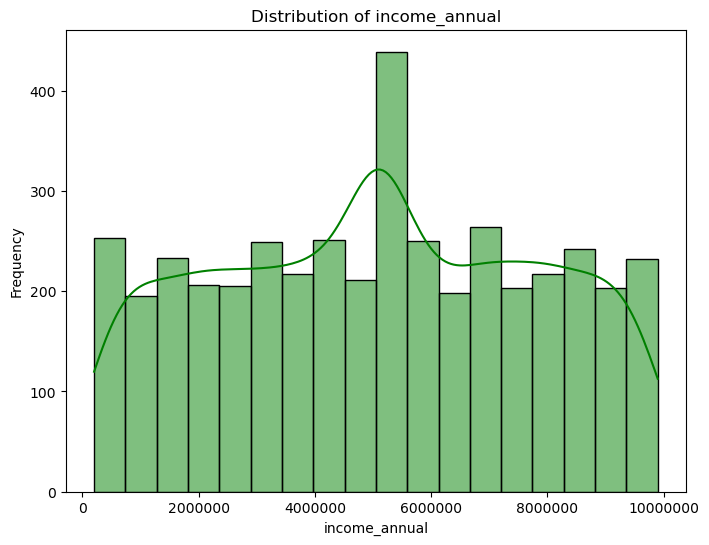

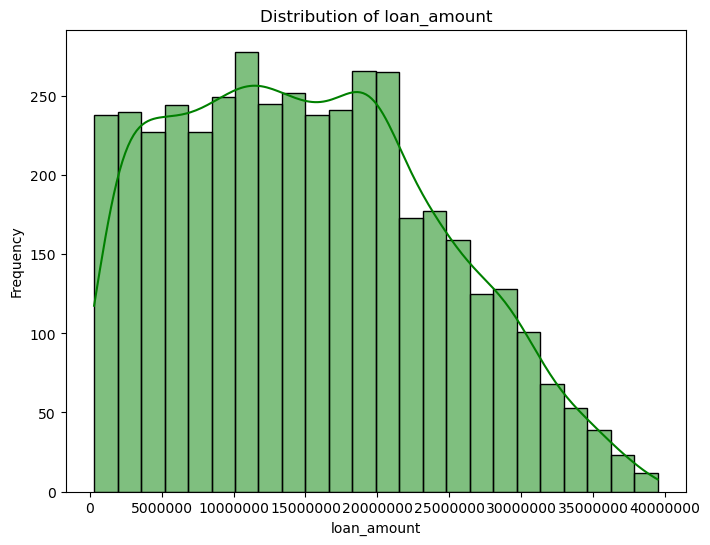

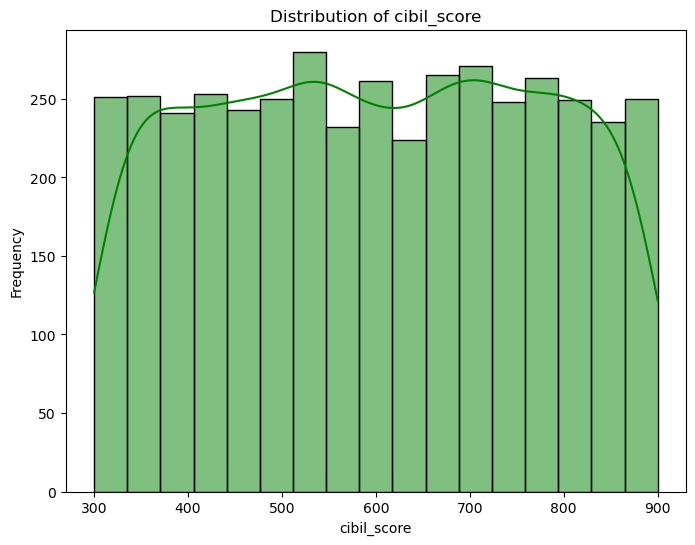

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms
numerical_col_vars = ['income_annual', 'loan_amount', 'cibil_score']
for var in numerical_col_vars:
    plt.figure(figsize=(8, 6))
    axis = sns.histplot(data=bank_data, x=var, kde=True, color='green')
    axis.ticklabel_format(style='plain', axis='x')  # Disable scientific notation
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()


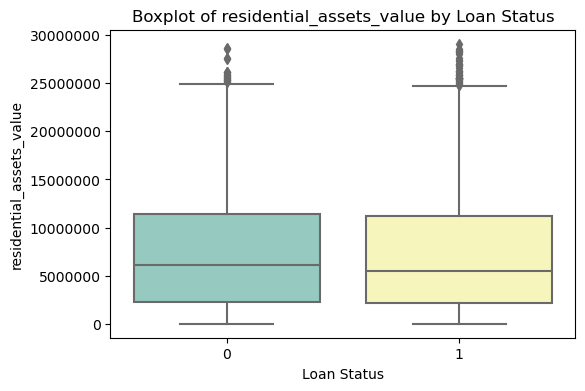

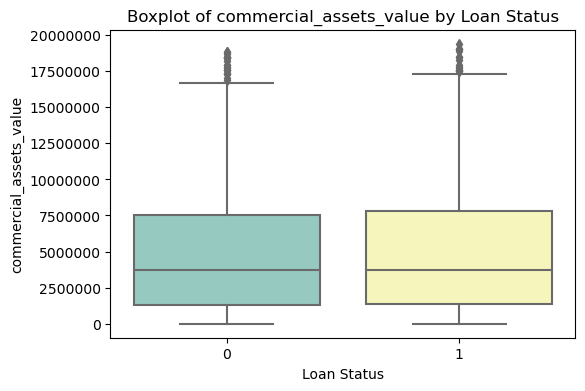

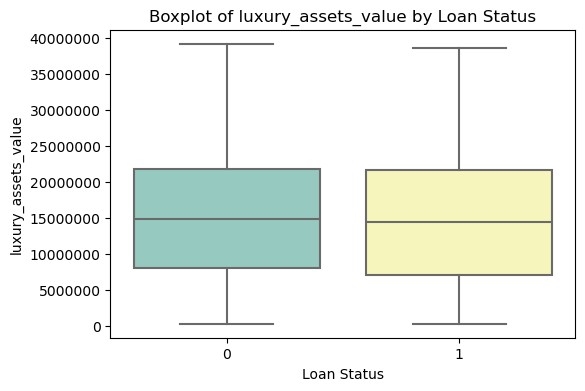

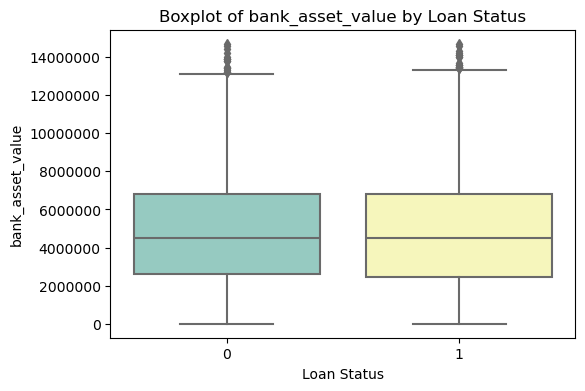

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting different numerical variables for box plots
other_numerical_vars = ['residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']

# Boxplots for the selected numerical variables
for var in other_numerical_vars:
    plt.figure(figsize=(6, 4))
    axis = sns.boxplot(x='loan_status', y=var, data=bank_data, palette='Set3')
    axis.ticklabel_format(style='plain', axis='y') 
    plt.title(f'Boxplot of {var} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(var)
    plt.show()

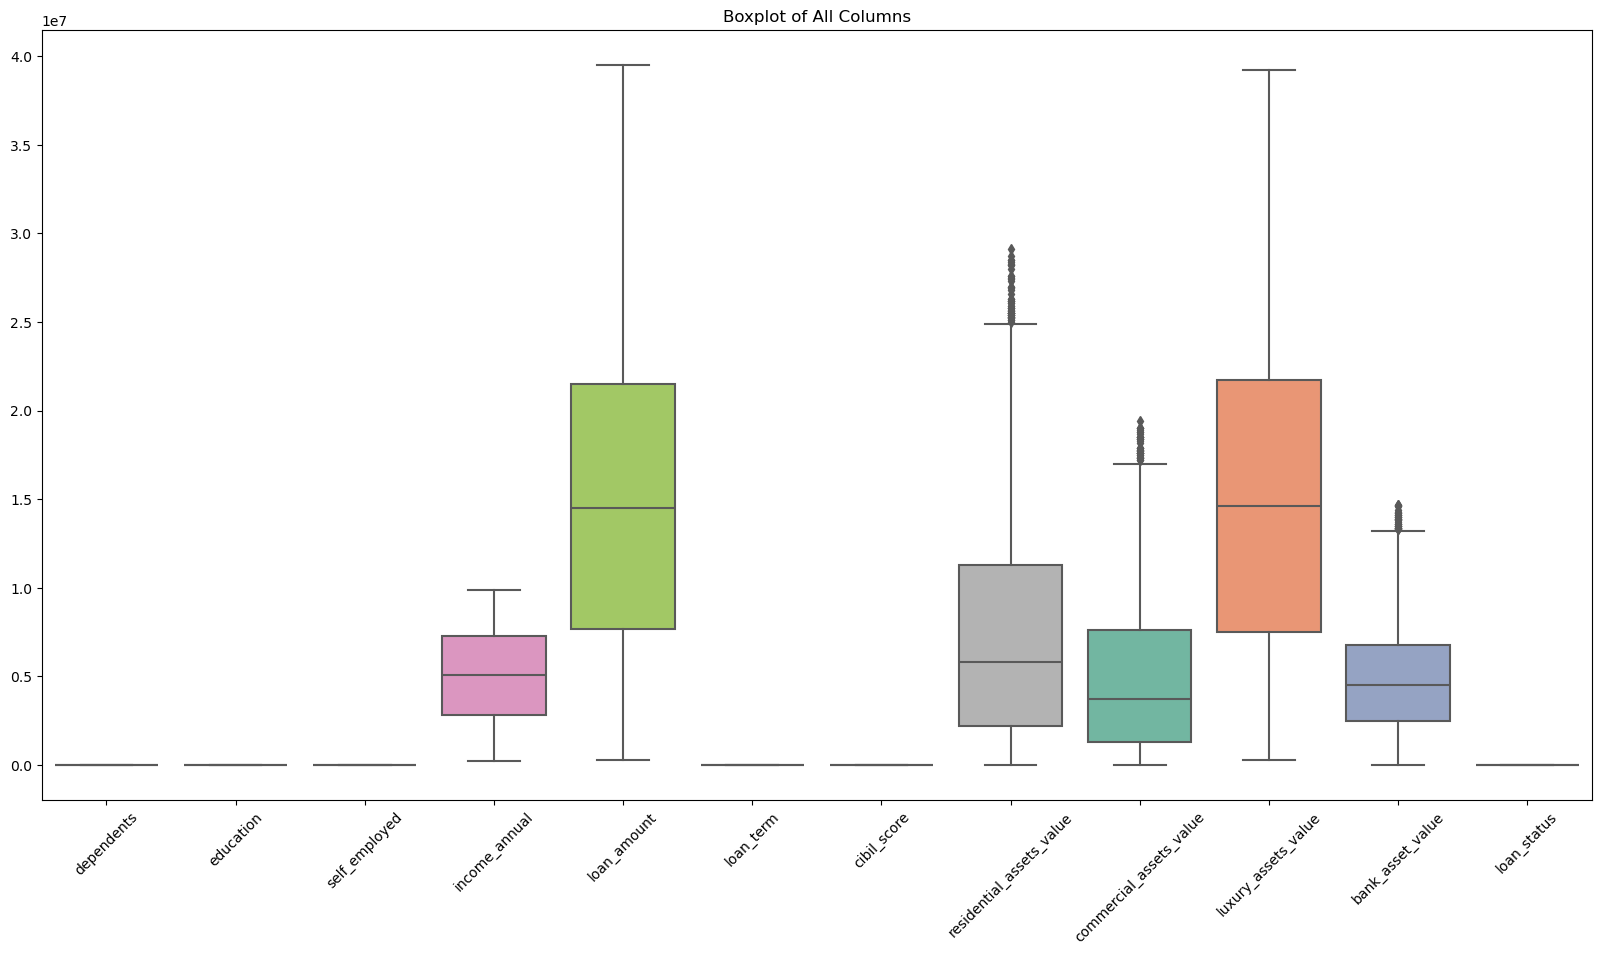

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplots for all columns
plt.figure(figsize=(20, 10))
sns.boxplot(data=bank_data, palette='Set2')
plt.title('Boxplot of All Columns')
plt.xticks(rotation=45)
plt.show()

In [65]:
bank_data.head()

,dependents,education,self_employed,income_annual,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000.0,29900000,12,778,2400000.0,17600000,22700000,4500000.0,1
1,0,0,1,4100000.0,12200000,8,417,2700000.0,2200000,8800000,3300000.0,0
2,3,1,0,9100000.0,29700000,20,506,7100000.0,4500000,33300000,12800000.0,0
3,3,1,0,8200000.0,30700000,8,467,18200000.0,3300000,23300000,7900000.0,0
4,5,0,1,9800000.0,24200000,20,382,12400000.0,8200000,29400000,5000000.0,0


In [66]:
# Calculate the correlation matrix for numerical columns
correlation_matrix = bank_data.corr()
correlation_matrix

,dependents,education,self_employed,income_annual,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
dependents,1.000000,0.002904,0.000557,0.009312,-0.003033,-0.020145,-0.009991,0.008234,-0.001210,0.003287,0.008374,-0.017956
education,0.002904,1.000000,-0.022994,0.013018,0.010259,-0.008381,-0.004659,0.012234,-0.007128,0.011952,0.008546,0.004737
self_employed,0.000557,-0.022994,1.000000,-0.004497,0.001831,0.004070,-0.004856,0.007044,-0.017638,0.004950,-0.001429,0.000529
income_annual,0.009312,0.013018,-0.004497,1.000000,0.901647,0.012515,-0.019911,0.617785,0.625112,0.902909,0.796866,-0.014084
loan_amount,-0.003033,0.010259,0.001831,0.901647,1.000000,0.008499,-0.017055,0.591217,0.602955,0.860838,0.754248,0.015861
loan_term,-0.020145,-0.008381,0.004070,0.012515,0.008499,1.000000,0.007811,0.007764,-0.005422,0.012581,0.012650,-0.113015
cibil_score,-0.009991,-0.004659,-0.004856,-0.019911,-0.017055,0.007811,1.000000,-0.018359,-0.003785,-0.028656,-0.015995,0.770566
residential_assets_value,0.008234,0.012234,0.007044,0.617785,0.591217,0.007764,-0.018359,1.000000,0.413127,0.587511,0.505198,-0.015535
commercial_assets_value,-0.001210,-0.007128,-0.017638,0.625112,0.602955,-0.005422,-0.003785,0.413127,1.000000,0.590825,0.527509,0.007965
luxury_assets_value,0.003287,0.011952,0.004950,0.902909,0.860838,0.012581,-0.028656,0.587511,0.590825,1.000000,0.756503,-0.015888


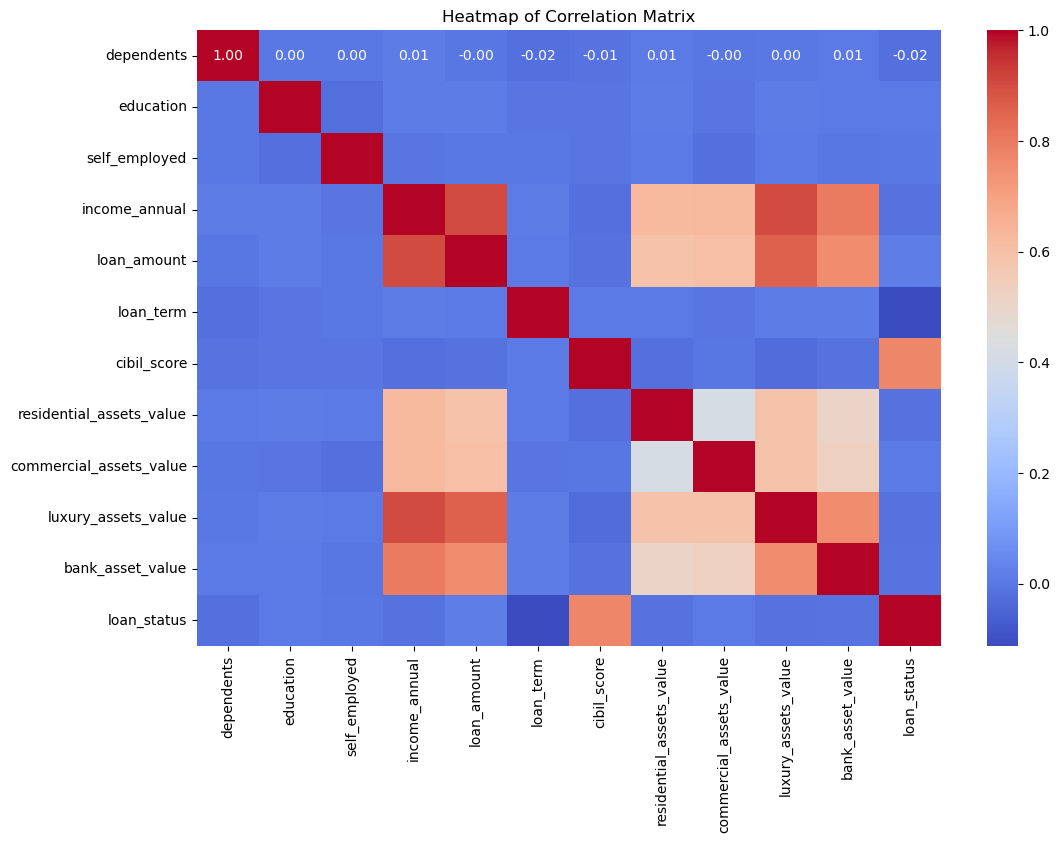

In [67]:
# Calculating the correlation matrix
correlation_matrix = bank_data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.show()


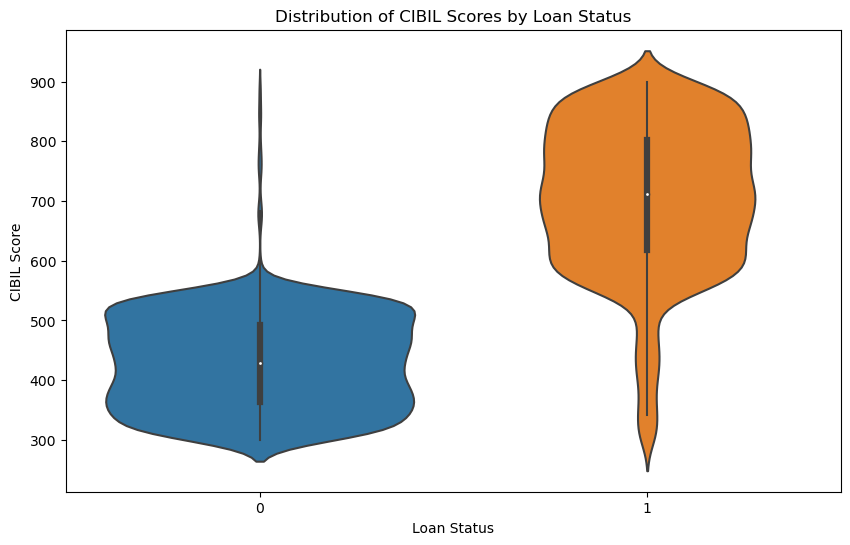

In [68]:
# Creating a violin plot for CIBIL scores by Loan Status
plt.figure(figsize=(10, 6))
sns.violinplot(x='loan_status', y='cibil_score', data=bank_data)
plt.title('Distribution of CIBIL Scores by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('CIBIL Score')
plt.show()

In [69]:
# Splitting data into features and target variable
X = bank_data.drop(['loan_status'], axis=1) 
Y = bank_data['loan_status']

In [70]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## SVM Model

In [71]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Fit on training data and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
from sklearn.svm import SVC

# Initializing and training the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)


SVC(kernel='linear', random_state=42)

In [73]:
from sklearn.metrics import accuracy_score, classification_report

# Predict the labels for the test set
y_pred = svm_model.predict(X_test_scaled)

# Calculate the accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9203747072599532
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89       303
           1       0.94      0.93      0.94       551

    accuracy                           0.92       854
   macro avg       0.91      0.91      0.91       854
weighted avg       0.92      0.92      0.92       854



### Hyperparameter Tuning

In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the model to be tuned
svm_classifier = SVC(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Type of SVM kernel to be used
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly'
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function (‘poly’).
}

In [75]:
# Setup the grid search with cross-validation
svm_grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5,scoring='accuracy', verbose=1)

# Fit the grid search to the data
svm_grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [76]:
# Print the best parameters and best score
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

Best parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.94


In [77]:
# Use the best estimator to make predictions on test data
y_pred_svm = svm_grid_search.best_estimator_.predict(X_test_scaled)

# Evaluate the best model on the test set
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Test set accuracy: {:.2f}".format(accuracy_svm))

Test set accuracy: 0.94


In [78]:
# Use the best estimator to make predictions on train data
y_pred_svm_train = svm_grid_search.best_estimator_.predict(X_train_scaled)

# Evaluate the best model on the train set
accuracy_svm_train = accuracy_score(y_train, y_pred_svm_train)
print("Train set accuracy: {:.2f}".format(accuracy_svm_train))

Train set accuracy: 0.98


In [79]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Calculate precision, recall, and F1 score
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1 Score:", f1_svm)

Precision: 0.9579524680073126
Recall: 0.9509981851179673
F1 Score: 0.9544626593806921


## Multilayer Perceptron

In [80]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50),  # This is the size of the hidden layer(s)
                    activation='relu',         # Activation function for the hidden layer
                    solver='adam',             # The solver for weight optimization
                    max_iter=300,              # Maximum number of iterations
                    random_state=42)          

In [81]:
# Fit the model to the scaled training data
mlp.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)

In [82]:
# Make predictions with the model
y_pred = mlp.predict(X_test_scaled)

# Calculate the accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9601873536299765
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       303
           1       0.97      0.97      0.97       551

    accuracy                           0.96       854
   macro avg       0.96      0.96      0.96       854
weighted avg       0.96      0.96      0.96       854



### Hyperparameter Tuning

In [83]:
from sklearn.model_selection import GridSearchCV

# Define the MLP model
mlp = MLPClassifier(max_iter=1000, random_state=42)  # Increase max_iter for convergence

# Define the parameter grid to search
parameter_space = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],  # 'sgd' removed as it tends to perform worse
    'alpha': [0.0001, 0.05],
    'learning_rate_init': [0.001, 0.01],  # Added learning_rate_init for learning rate adjustment
}

In [84]:
# Set up GridSearchCV
mlp_grid_search = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3,scoring='accuracy', verbose=2)

# Fit GridSearchCV
mlp_grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'learning_rate_init': [0.001, 0.01],
                         'solver': ['adam']},
             scoring='accuracy', verbose=2)

In [85]:
# Best parameter set
print('Best parameters found:\n', mlp_grid_search.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001, 'solver': 'adam'}


In [86]:
means = mlp_grid_search.cv_results_['mean_test_score']
stds = mlp_grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mlp_grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.962 (+/-0.016) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'adam'}
0.955 (+/-0.010) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'solver': 'adam'}
0.958 (+/-0.014) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'adam'}
0.958 (+/-0.014) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'solver': 'adam'}
0.960 (+/-0.015) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001, 'solver': 'adam'}
0.964 (+/-0.014) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
0.965 (+/-0.007) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001, 'solver': 'adam'}
0.958 (+/-0.033) for {'activati

In [87]:
# Predict on the test set using the best model
y_pred_mlp = mlp_grid_search.best_estimator_.predict(X_test_scaled)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
accuracy_mlp

0.9660421545667447

In [88]:
# Print classification report
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       303
           1       0.97      0.98      0.97       551

    accuracy                           0.97       854
   macro avg       0.97      0.96      0.96       854
weighted avg       0.97      0.97      0.97       854



In [89]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Calculate precision, recall, and F1 score
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

print("Precision:", precision_mlp)
print("Recall:", recall_mlp)
print("F1 Score:", f1_mlp)

Precision: 0.9660714285714286
Recall: 0.9818511796733213
F1 Score: 0.9738973897389739


In [90]:
# Predict on the train set using the best model
y_pred_mlp_train = mlp_grid_search.best_estimator_.predict(X_train_scaled)

accuracy_mlp_train = accuracy_score(y_train, y_pred_mlp_train)
accuracy_mlp_train

0.9824253075571178

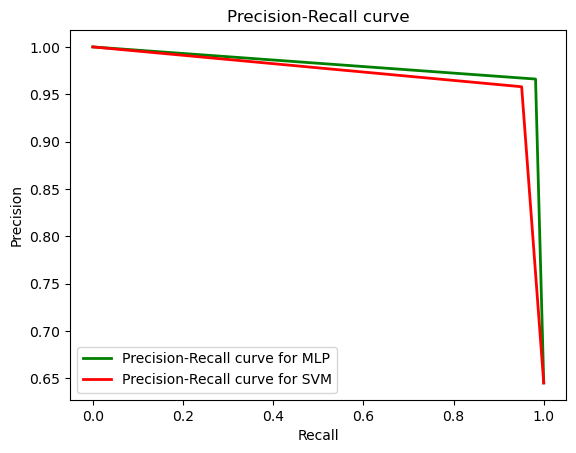

In [91]:
from sklearn.metrics import precision_recall_curve

precision_mlp, recall_mlp, _ = precision_recall_curve(y_test, y_pred_mlp)
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_svm)

plt.figure()
plt.plot(recall_mlp, precision_mlp, color='green', lw=2, label='Precision-Recall curve for MLP')
plt.plot(recall_svm, precision_svm, color='red', lw=2, label='Precision-Recall curve for SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

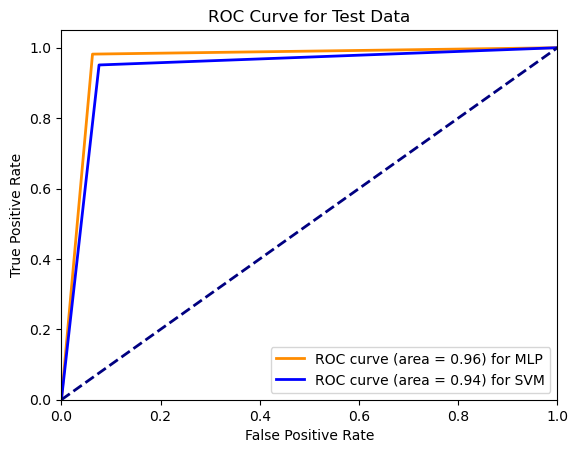

In [92]:
from sklearn.metrics import roc_curve, auc

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label='ROC curve (area = %0.2f) for MLP' % roc_auc_mlp)
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='ROC curve (area = %0.2f) for SVM' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data')
plt.legend(loc="lower right")
plt.show()


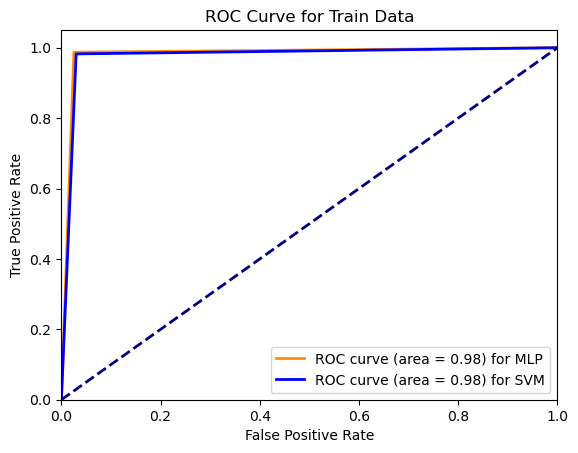

In [93]:
from sklearn.metrics import roc_curve, auc

fpr_mlp, tpr_mlp, _ = roc_curve(y_train, y_pred_mlp_train)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

fpr_svm, tpr_svm, _ = roc_curve(y_train, y_pred_svm_train)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label='ROC curve (area = %0.2f) for MLP' % roc_auc_mlp)
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='ROC curve (area = %0.2f) for SVM' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Train Data')
plt.legend(loc="lower right")
plt.show()

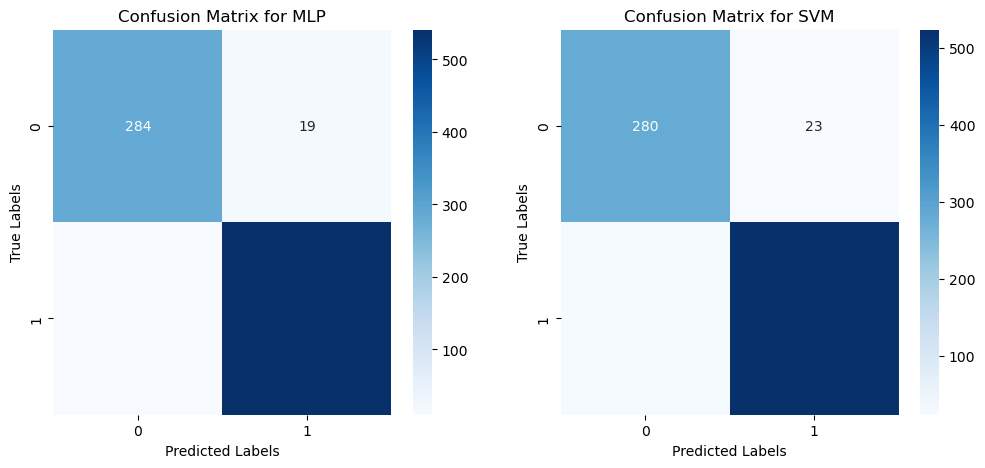

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cnfusn_mlp = confusion_matrix(y_test, y_pred_mlp)
cnfusn_svm = confusion_matrix(y_test, y_pred_svm)

fig, axis = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cnfusn_mlp, annot=True, fmt='d', cmap='Blues', ax=axis[0])
axis[0].set_title('Confusion Matrix for MLP')
axis[0].set_xlabel('Predicted Labels')
axis[0].set_ylabel('True Labels')

sns.heatmap(cnfusn_svm, annot=True, fmt='d', cmap='Blues', ax=axis[1])
axis[1].set_title('Confusion Matrix for SVM')
axis[1].set_xlabel('Predicted Labels')
axis[1].set_ylabel('True Labels')
plt.show()

In [95]:
# We will create a DataFrame with test features and labels
test_bank_data = pd.DataFrame(X_test_scaled)
test_bank_data.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
test_bank_data['True_Label'] = y_test  # Add the true labels as a new column in the DataFrame

# Save the DataFrame to a CSV file
test_bank_data.to_csv('test_data.csv', index=False)  # Set index=False not to save the index

from joblib import dump

# Saving the models to file
dump(mlp_grid_search, 'mlp_grid_search.joblib')
dump(svm_grid_search, 'svm_grid_search.joblib')

['svm_grid_search.joblib']

[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.01, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, solver=adam; total time=   4.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.01, solver=adam; total time=   1.0s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(50,), learning_rate_init=0.01, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate_init=0.001, solver=adam; total time=   2.9s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 100), learning_rate_init=0.001, solver=adam; total time=   2.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate_init=0.001, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate_init=0.001, solver=adam; total time=   2.8s